# Compare cell motility in pools versus wells
---

#### Overview

In this notebook we explore how summary motility metrics depend on the type of vessel in which the cells are swimming: either agar microchambers or 384-well plates. We anticipate that changes in the motility statistics will reflect the vast difference in confinement that the cells experience --- the volume of liquid in which the cells have to swim is roughly 50x greater in the wells than in pools.

Output from this notebook was used to generate Figure 7 in the [pub](https://doi.org/10.57844/arcadia-2d61-fb05).

In [1]:
import string
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from chlamytracker.stats_testing import joint_grid_with_stats, split_violin_plot_with_stats

Configure matplotlib styles to match the Arcadia style guide

In [2]:
import arcadia_pycolor as apc

apc.mpl.setup()

## Load motility metrics
---

Load summary motility metrics from all _C. Reinhardtii_ cells swimming in pools and wells. This data is stored in `../data/AMID-04_summary_motility_metrics.csv` and `../data/AMID-05_summary_motility_metrics.csv`, respectively. Both csv files were generated by running [`1_compute-summary-motility-metrics.ipynb`](./1_compute-summary-motility-metrics.ipynb).

#### Experimental parameters

| strain  | vessel type | position_in_tube | time_in_water |
|---------|-------------|------------------|---------------|
| CC-124  | pools       | top              | 4 hrs         |
|         | wells       | middle           | 21 hrs        |

Strain [CC-124](https://www.chlamycollection.org/product/cc-124-wild-type-mt-137c/) corresponds to _C. Reinhardtii_.

#### Collect csv files

In [3]:
csv_files = {
    "AMID-04": Path("../data/AMID-04_summary_motility_metrics.csv"),
    "AMID-05": Path("../data/AMID-05_summary_motility_metrics.csv"),
}

motility_metrics_dataframe = pd.concat(
    [pd.read_csv(csv_file) for csv_file in csv_files.values()],
)

# preview dataframe
motility_metrics_dataframe.drop("slide_ID", axis=1).groupby("experiment_ID").head(4)

,total_time,total_distance,net_distance,max_sprint_length,confinement_ratio,mean_curvilinear_speed,mean_linear_speed,mean_angular_speed,num_rotations,num_direction_changes,pivot_rate,cell_count,experiment_ID,strain,vessel_type,position_in_tube,time_in_water,well_ID,timelapse_ID,pool_ID
0,14.602920,723.059408,51.339131,22.719548,0.071003,49.514714,3.515676,3.595302,0.0,33,0.045639,1,AMID-04,cc124,pools,top,21,NaN,1.0,2x0
1,10.102020,420.157509,91.028098,16.674224,0.216652,41.591435,9.010881,3.086678,0.0,17,0.040461,1,AMID-04,cc124,pools,top,21,NaN,1.0,3x0
2,13.152630,542.448425,13.260461,19.222859,0.024446,41.242582,1.008198,3.834459,1.0,29,0.053461,2,AMID-04,cc124,pools,top,21,NaN,1.0,3x1
3,13.202640,488.403215,57.604801,19.530733,0.117945,36.992845,4.363127,4.063902,4.0,37,0.075757,2,AMID-04,cc124,pools,top,21,NaN,1.0,3x1
0,16.853439,288.823532,131.213339,6.633705,0.454303,17.137365,7.785553,2.682857,1.0,23,0.079633,7,AMID-05,cc124,wells,middle,21,I03,NaN,NaN
1,12.002449,338.574973,181.656255,10.339470,0.536532,28.208823,15.134932,4.863860,0.0,41,0.121096,7,AMID-05,cc124,wells,middle,21,I03,NaN,NaN
2,13.052664,28.818979,3.345305,1.083630,0.116080,2.207900,0.256293,14.393410,3.0,115,3.990426,7,AMID-05,cc124,wells,middle,21,I03,NaN,NaN
3,11.052255,166.604696,104.434283,10.092440,0.626839,15.074271,9.449138,3.148121,0.0,20,0.120045,7,AMID-05,cc124,wells,middle,21,I03,NaN,NaN


## 1D analysis
---

#### Define experimental variables and motility metrics

In [4]:
# set metrics and map to axis labels for the plot
metrics_subset = {
    "confinement_ratio": "Confinement ratio",
    "mean_curvilinear_speed": "Mean curvilinear speed (µm/s)",
    "mean_angular_speed": "Mean angular speed (rad/s)",
}

# set experimental variables
experimental_variables = [
    "vessel_type",
]

# set color palettes in accordance with experimental variables
palettes = {
    "time_in_water": ["#73B5E3", "#377BB7"],
    "position_in_tube": ["#B5BEA4", "#596F74"],
    "vessel_type": ["#F28360", "#7A77AB"],
}

#### Split violin plots
Generate univariate KDE plots (in this case, split violins) of chosen motility metrics for cells grouped by vessel type.

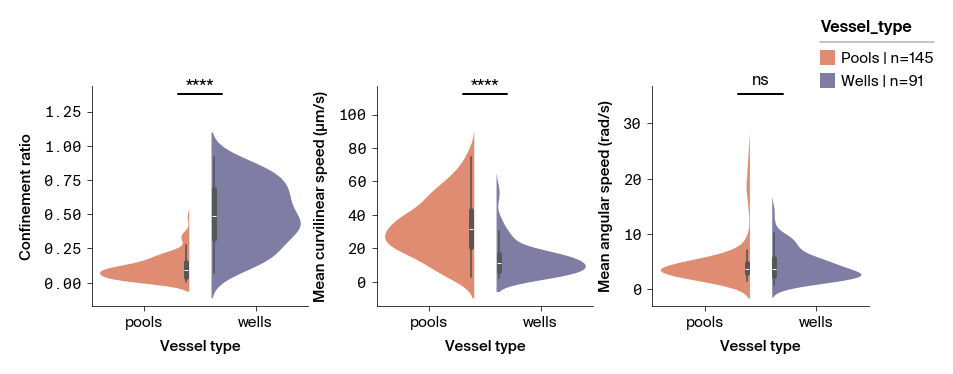

In [5]:
source = motility_metrics_dataframe.copy()

# loop through experimental variables
for experimental_variable in experimental_variables:
    # create figure
    ncols = len(metrics_subset)
    figsize = apc.mpl.get_figure_dimensions("full_wide")
    fig, axes = plt.subplots(
        ncols=ncols,
        figsize=figsize,
        layout="constrained",
    )

    # loop through select metrics
    for i, (metric, ylabel) in enumerate(metrics_subset.items()):
        last = len(metrics_subset) - 1
        legend = True if i == last else False

        # render violin plot
        ax = split_violin_plot_with_stats(
            data=source,
            x_variable=experimental_variable,
            y_variable=metric,
            hue_variable=experimental_variable,
            palette=palettes[experimental_variable],
            inner="box",
            inner_kws={"box_width": 5},
            fill=True,
            legend=legend,
            ax=axes.flat[i],
        )

        # monospace numerical axes
        apc.mpl.style_plot(ax, monospaced_axes="y")
        # set x, y axes labels
        xlabel = ax.xaxis.label.get_text()
        ax.set_xlabel(xlabel.replace("_", " "))
        ax.set_ylabel(ylabel)

    # reposition and stylize the legend
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1.3))
    apc.mpl.style_plot(ax)

## 2D analysis
---

#### Bivariate distributions

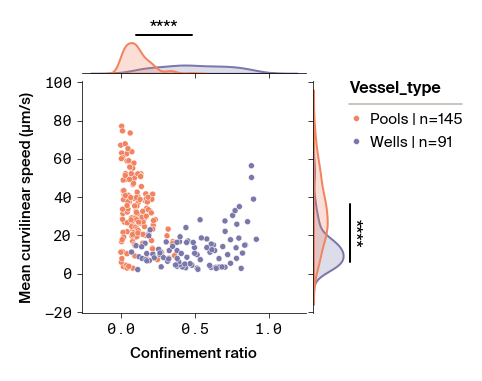

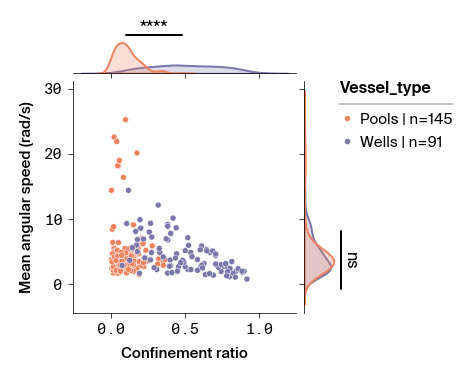

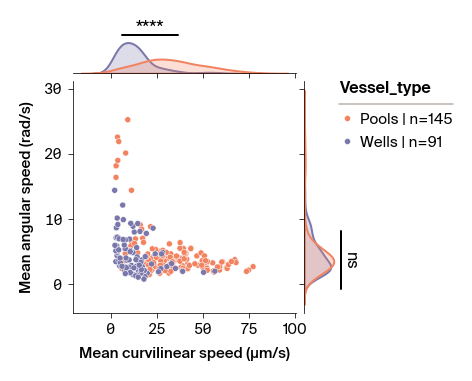

In [6]:
metrics_combinations = list(combinations(metrics_subset.keys(), 2))
source = motility_metrics_dataframe.copy()

# loop through experimental variables
for experimental_variable in experimental_variables:
    # loop through combinations of motility metrics
    for i, (metric_i, metric_j) in enumerate(metrics_combinations):
        # render joint distributions with stats
        g = joint_grid_with_stats(
            data=source,
            x_variable=metric_i,
            y_variable=metric_j,
            hue_variable=experimental_variable,
            palette=palettes[experimental_variable],
            height=5,
        )

        # set x, y axes labels
        xlabel = metrics_subset[metric_i]
        ylabel = metrics_subset[metric_j]
        g.ax_joint.set_xlabel(xlabel)
        g.ax_joint.set_ylabel(ylabel)
        # aesthetics
        sns.move_legend(g.ax_joint, "upper right", bbox_to_anchor=(1.7, 1))
        apc.mpl.style_plot(g.ax_joint, monospaced_axes="both")

        # save figure
        panel = string.ascii_uppercase[i]
        apc.mpl.save_figure(f"../results/figure-6{panel}.svg")